In [402]:
%matplotlib inline
import numpy as np
import scipy as sp
import copy
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [403]:
df = pd.read_csv('./../data/user_post_date_from_day_of_joining.csv')
df_silver_badge_date = pd.read_csv('./../data/user_badge_date.csv')
df.head()

,UserId,days,edit_count
0,9143011,4,26
1,9143011,2,8
2,9143011,1,1
3,9143011,3,33
4,9143011,0,1


In [404]:
user = np.random.choice(df.UserId.unique())
user_df = df[df.UserId == user]
badge = df_silver_badge_date[df_silver_badge_date.UserId == user]
badge.days.values[0]
max_ = df.weeks.max()
work = np.zeros(max_ + 1)
for w, edits in user_df.groupby('weeks'):
    work[w] = edits.edit_count.sum()
work

AttributeError: 'DataFrame' object has no attribute 'weeks'

In [405]:
print(f'We have {len(df.UserId.unique())} users')

We have 428 users


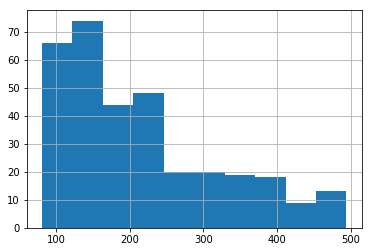

In [406]:
user_edits = df.groupby('UserId').agg('sum').edit_count
users_who_got_silver = user_edits[(user_edits > 80 )& (user_edits < 500)].index
user_edits.loc[users_who_got_silver].hist()

In [407]:
df = df[df.UserId.isin(users_who_got_silver)]
num_users = len(df.UserId.unique())
print(f'We have {num_users} users')

We have 331 users


In [408]:
# take one users edits history.
# DEFINE: 'consistency' number of days in a week that the user made at least one edit
# DEFINE: 'consistency_difference' the forward difference in 'consistency'
df['weeks'] = df.days // 7
df['count_this_week'] = np.zeros_like(df.weeks)
df.head()

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,UserId,days,edit_count,weeks,count_this_week
6,8840085,1,2,0,0
7,8840085,5,20,0,0
8,8840085,6,50,0,0
9,8840085,21,2,3,0
10,8840085,4,28,0,0


In [409]:
def find_week_count(row):
    num_days_this_week = df[(df.UserId == row.UserId) & (df.weeks == row.weeks)].shape[0]
    return num_days_this_week
df.count_this_week = df.apply(find_week_count, axis=1)

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [410]:
df.head(10)

,UserId,days,edit_count,weeks,count_this_week
6,8840085,1,2,0,4
7,8840085,5,20,0,4
8,8840085,6,50,0,4
9,8840085,21,2,3,1
10,8840085,4,28,0,4
11,8840085,7,2,1,2
12,8840085,8,2,1,2
13,8830634,34,2,4,3
14,8830634,50,11,7,7
15,8830634,52,2,7,7


In [411]:
consistency =  np.zeros(shape=(num_users, df.weeks.max()+1))
index = 0
for i, user in df.groupby('UserId'):
    for j,row in user.iterrows():
        # note that this is not a unique index but the count will be the 
        # same per week so we are only doing extra work but are not necessarily 
        # getting the wrong answer
        consistency[index, row.weeks] = row.count_this_week
    index += 1

In [412]:
print(consistency.shape)
consistency

(331, 83)


array([[0., 3., 4., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 4., ..., 0., 0., 0.],
       [2., 1., 1., ..., 0., 0., 0.],
       [4., 2., 0., ..., 0., 0., 0.]])

In [413]:
consistency_difference = np.diff(consistency, axis=1)
print(consistency_difference.shape)
consistency_difference

(331, 82)


array([[ 3.,  1., -4., ...,  0.,  0.,  0.],
       [-1.,  0.,  2., ...,  0.,  0.,  0.],
       [ 1., -1.,  0., ..., -2.,  0.,  0.],
       ...,
       [ 1.,  3., -1., ...,  0.,  0.,  0.],
       [-1.,  0., -1., ...,  0.,  0.,  0.],
       [-2., -2.,  1., ...,  0.,  0.,  0.]])

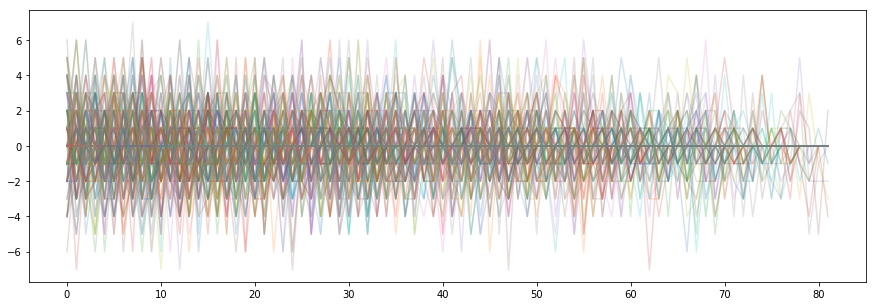

In [414]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
for user_traj in consistency_difference:
    ax.plot(user_traj, alpha=.2)

In [517]:
df.head()

,UserId,days,edit_count,weeks,count_this_week
6,8840085,1,2,0,4
7,8840085,5,20,0,4
8,8840085,6,50,0,4
9,8840085,21,2,3,1
10,8840085,4,28,0,4


In [397]:
# center the trajectories on arbitrary counts
consistency = np.zeros(shape=(num_users, 2*df.weeks.max()))
index = 0
for i, user in df.groupby('UserId'):
    user.sort_values('days', inplace=True)
    total_edits = user.set_index('weeks')
    total_edits = total_edits.edit_count.cumsum()

    target = total_edits[total_edits > (total_edits.values[-1] - 60)].index
    if len(target) > 0:
        week_of_interest = target[0]
        for j,row in user.iterrows():
            # note that this is not a unique index but the count will be the 
            # same per week so we are only doing extra work but are not necessarily 
            # getting the wrong answer
            consistency[index, df.weeks.max()+row.weeks-week_of_interest] = row.count_this_week
    index += 1

/home/nick/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [398]:
consistency.shape
# consistency = consistency[consistency.sum(axis=1) > 90]

(331, 164)

In [399]:
consistency_difference = np.diff(consistency, axis=1)

In [400]:
consistency_difference.shape

(331, 163)

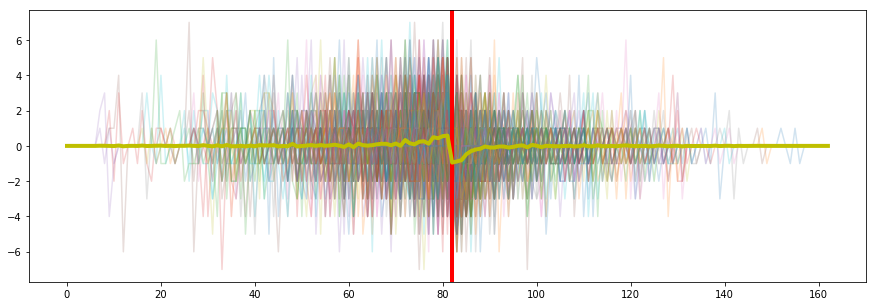

In [401]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
for user_traj in consistency_difference:
    ax.plot(user_traj, alpha=.2)
#     break
ax.axvline(df.weeks.max(), c='r', lw=4)
ax.plot(np.mean(consistency_difference, axis=0), c='y', lw=4)
plt.show()

In [415]:
from sklearn import mixture

In [416]:
bdge_max = (df_silver_badge_date.days.values // 7).max()
# wks = int(df.groupby('UserId').agg('min').days.max()//7)
# wks

In [438]:
work = np.zeros(shape=(num_users, df.days.max()+1))
index = 0
for i, user in df.groupby('UserId'):
    min_weeks = user.days.min()
    for j,row in user.iterrows():
#         bdge = df_silver_badge_date[df_silver_badge_date.UserId == user.UserId.values[0]]
        ix = row.days
#         if bdge.shape[0] > 0:
#             ix = bdge_max + j - bdge.days.values[0]//7
#         ix = min_weeks
        work[index, ix] = row.edit_count
    index += 1

In [439]:
y = work[0]
X = np.arange(len(y)).reshape(-1,1)
y

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        2.,  0.,  6.,  2.,  0.,  0.,  1.,  5.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  6., 11.,  0.,  0.,  0.,  0.,  2.,  6., 19., 13.,  0.,
        0.,  1.,  3., 10.,  0.,  0.,  0.,  0., 12., 11.,  7.,  2.,  0.,
        0.,  0.,  3.,  4.,  2., 18.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [405]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1, length_scale_bounds=(1,10))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=5)
gpr.fit(X, y)

GaussianProcessRegressor(alpha=5, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [406]:
gpr.kernel_.length_scale

3.1353698137761046

In [407]:
mean, std = gpr.predict(X, return_std=True)
std

array([0.80097088, 0.75414453, 0.72511516, 0.71221246, 0.70845708,
       0.70791185, 0.7079082 , 0.70786668, 0.70781651, 0.7077946 ,
       0.70779032, 0.70779018, 0.70779004, 0.70778981, 0.70778969,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778966, 0.70778966,
       0.70778966, 0.70778966, 0.70778966, 0.70778969, 0.70778981,
       0.70779004, 0.70779018, 0.70779032, 0.7077946 , 0.70781

In [408]:
X[:,0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

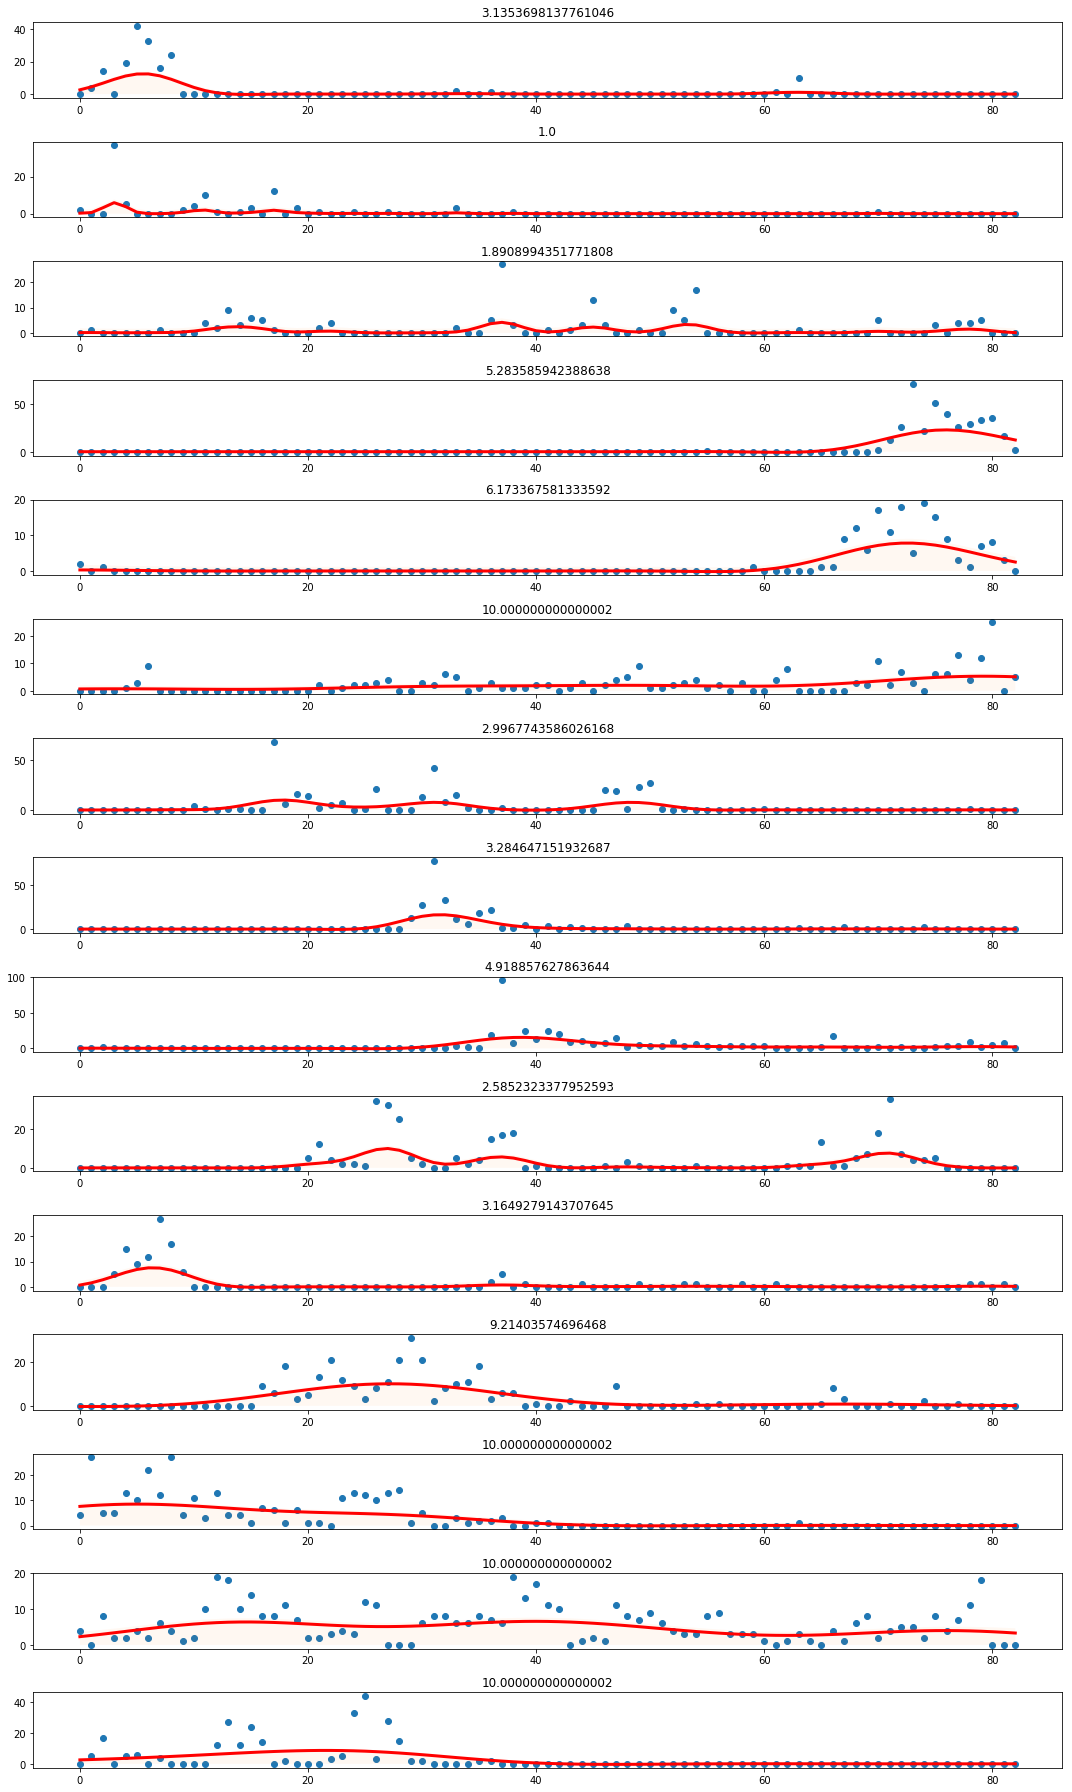

In [409]:
fig, ax = plt.subplots(15,figsize=(15,25))

for i in range(15):
    y = work[i]
    X = np.arange(len(y)).reshape(-1,1)
    gpr.fit(X, y)
    ax[i].scatter(X, y)
    mean, std = gpr.predict(X, return_std=True)
    ax[i].plot(mean, label=gpr.kernel_.length_scale, lw=3, c='r')
    ax[i].fill_between(X[:,0], mean + 2*std, alpha=.05)
    ax[i].set_title(gpr.kernel_.length_scale)
# ax.legend(loc='best')
fig.tight_layout()

In [424]:
output = []
max_rate = []
for y in work:
    X = np.arange(len(y)).reshape(-1,1)
    gpr.fit(X, y)
    mean, std = gpr.predict(X, return_std=True)
    output.append(gpr.kernel_.length_scale)
    max_rate.append(np.argmax(gpr.predict(X)))

(array([39., 52., 64., 36., 32., 19., 17., 17.,  9., 46.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

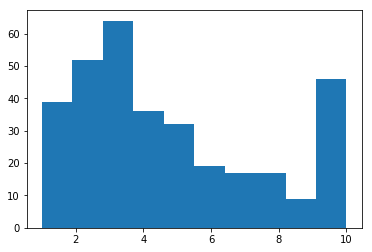

In [411]:
plt.hist(output)

In [412]:
np.where(np.array(output) < 2)[0][:15]

array([  1,   2,  21,  28,  34,  43,  58,  63,  78,  84,  86,  98, 101,
       107, 110])

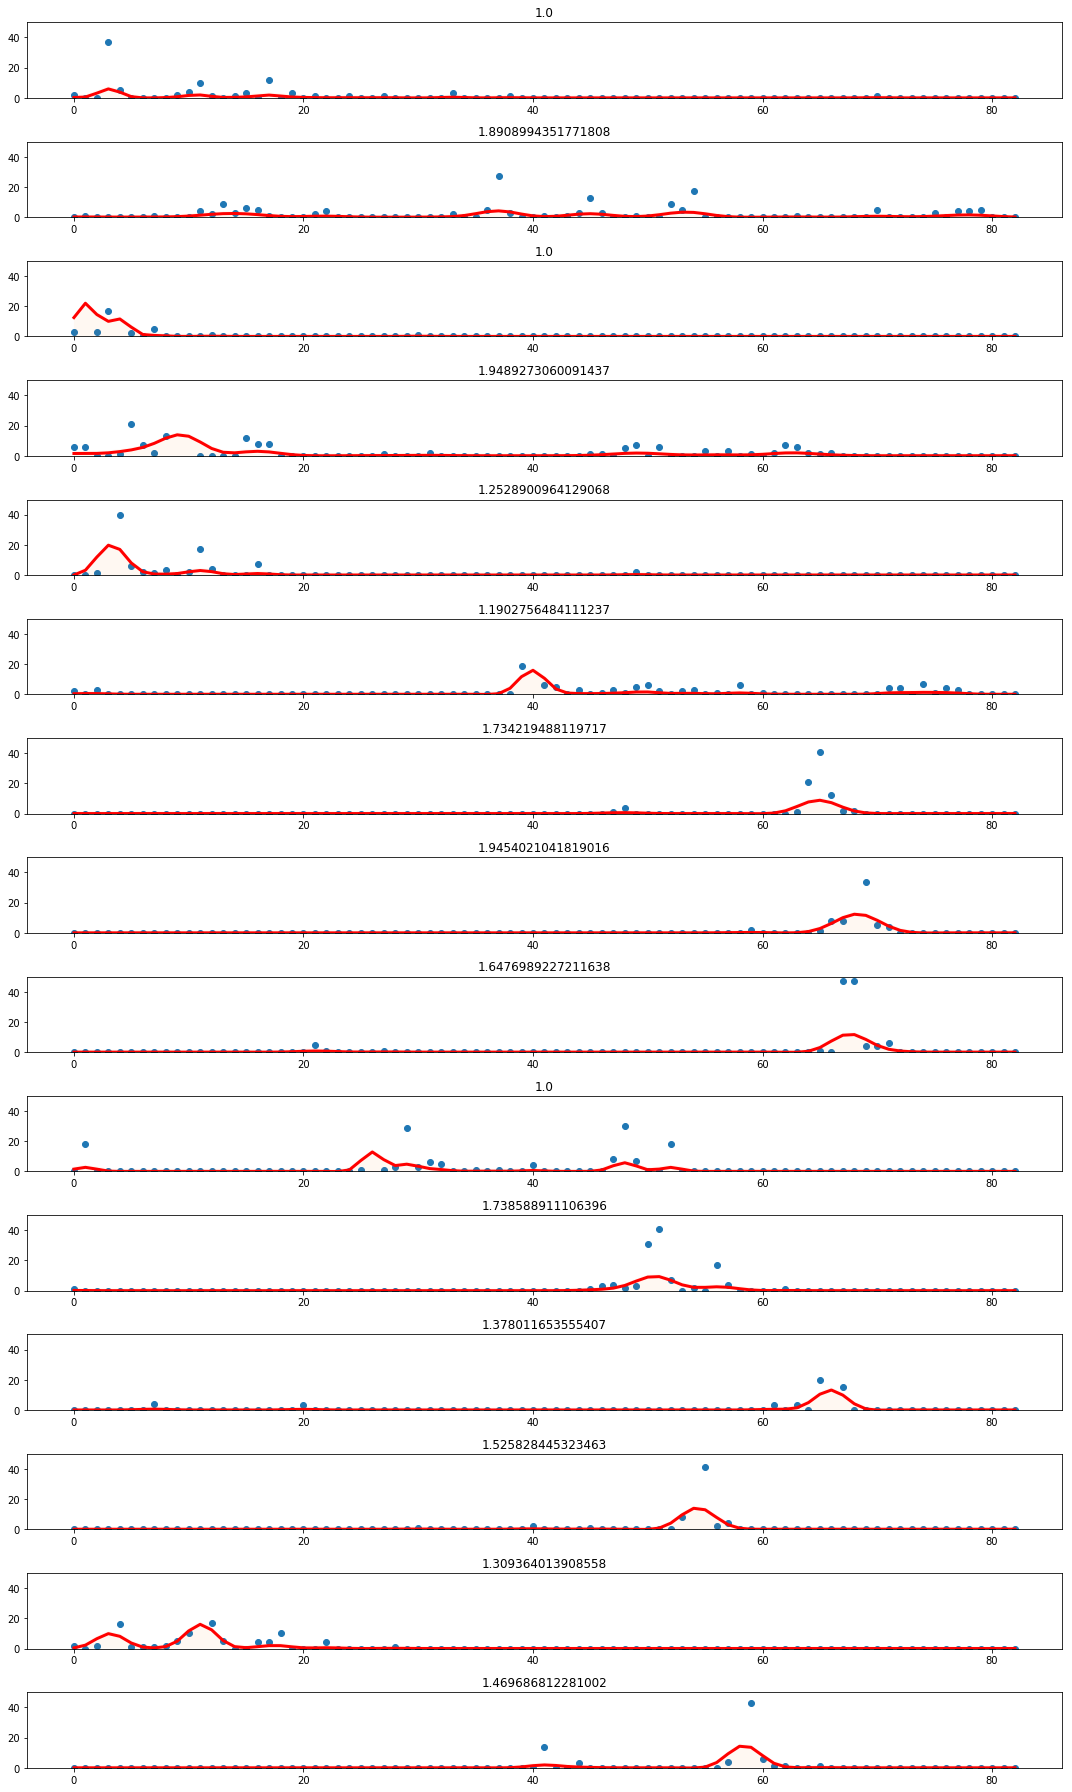

In [419]:
fig, ax = plt.subplots(15,figsize=(15,25))
i = 0
for j in np.where(np.array(output) < 2)[0][:15]:
    
    y = work[j]
    X = np.arange(len(y)).reshape(-1,1)
    gpr.fit(X, y)
    mean, std = gpr.predict(X, return_std=True)
    
    ax[i].scatter(X[:,0], y)
    ax[i].plot(mean, label=gpr.kernel_.length_scale, lw=3, c='r')
    ax[i].fill_between(X[:,0], mean + 2*std, alpha=.05)
    ax[i].set_title(gpr.kernel_.length_scale)
    ax[i].set_ylim([0,50])
    i += 1
# ax.legend(loc='best')
fig.tight_layout()

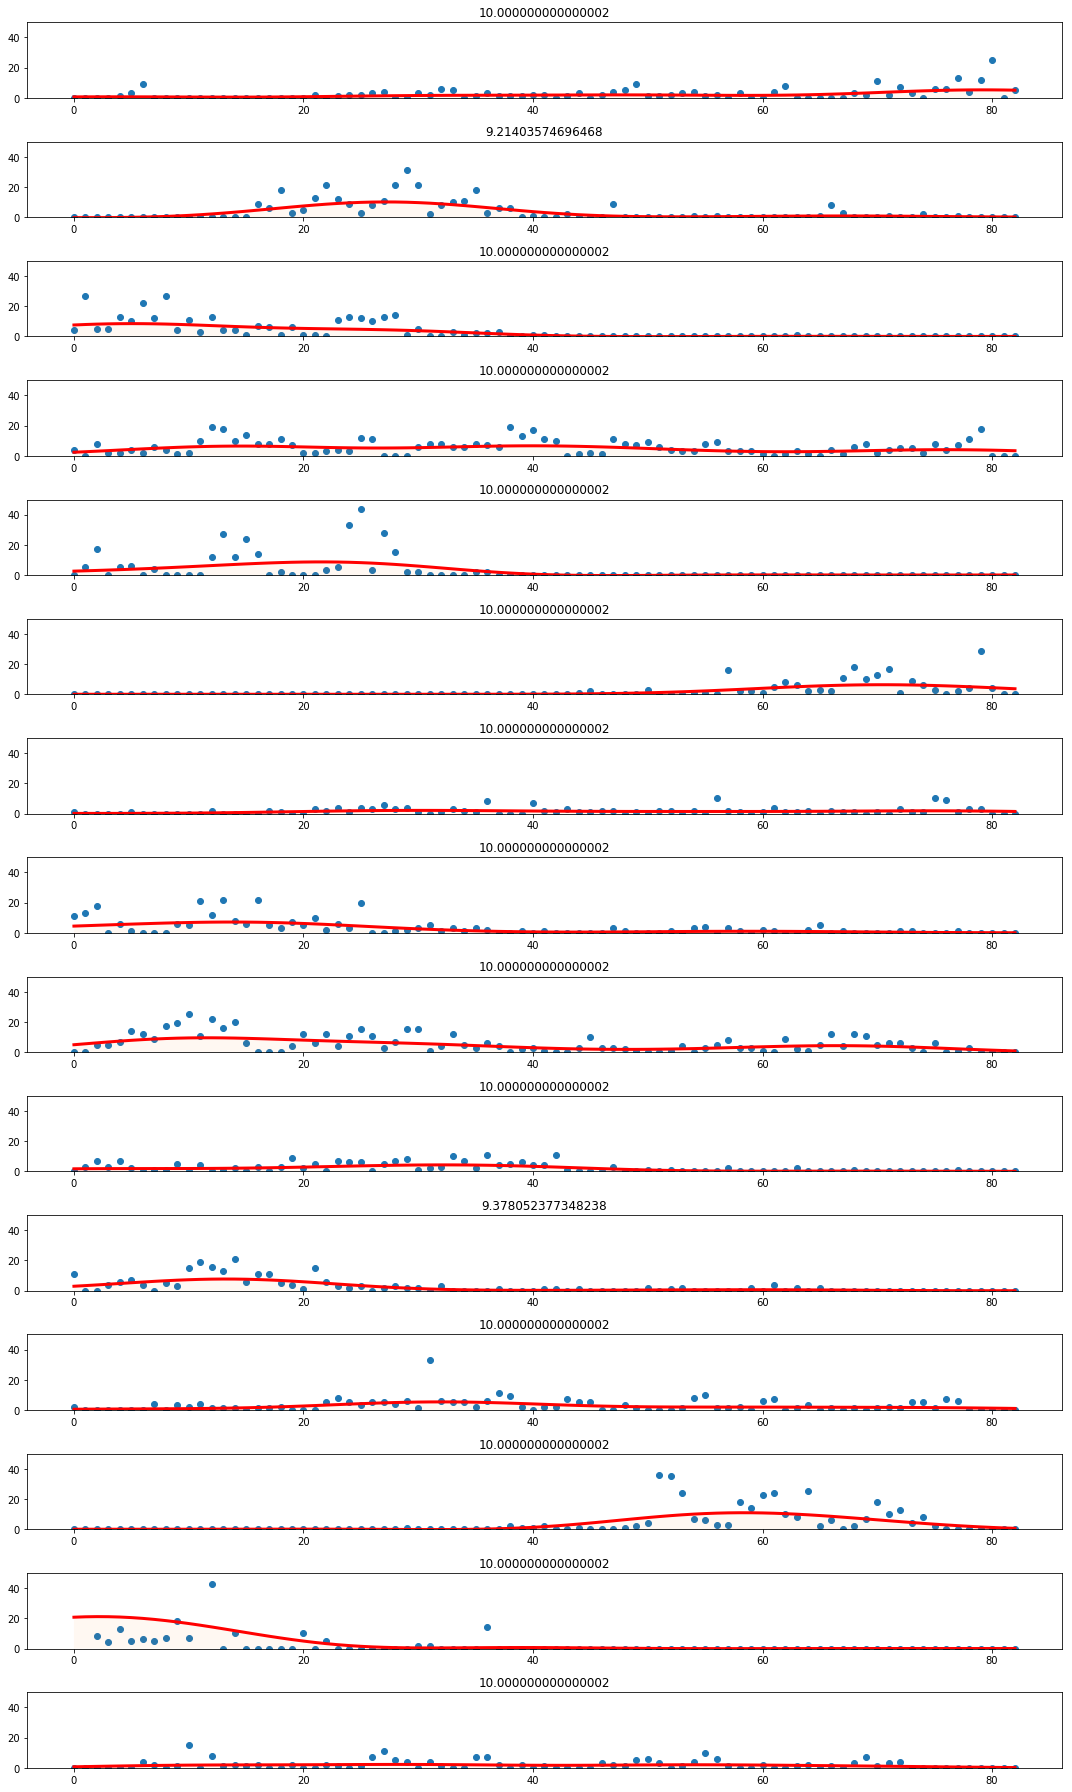

In [420]:
fig, ax = plt.subplots(15,figsize=(15,25))
i = 0
for j in np.where(np.array(output) > 9)[0][:15]:
    
    y = work[j]
    X = np.arange(len(y)).reshape(-1,1)
    gpr.fit(X, y)
    mean, std = gpr.predict(X, return_std=True)
    
    ax[i].scatter(X[:,0], y)
    ax[i].plot(mean, label=gpr.kernel_.length_scale, lw=3, c='r')
    ax[i].fill_between(X[:,0], mean + 2*std, alpha=.05)
    ax[i].set_title(gpr.kernel_.length_scale)
    ax[i].set_ylim([0,50])
    i += 1
# ax.legend(loc='best')
fig.tight_layout()

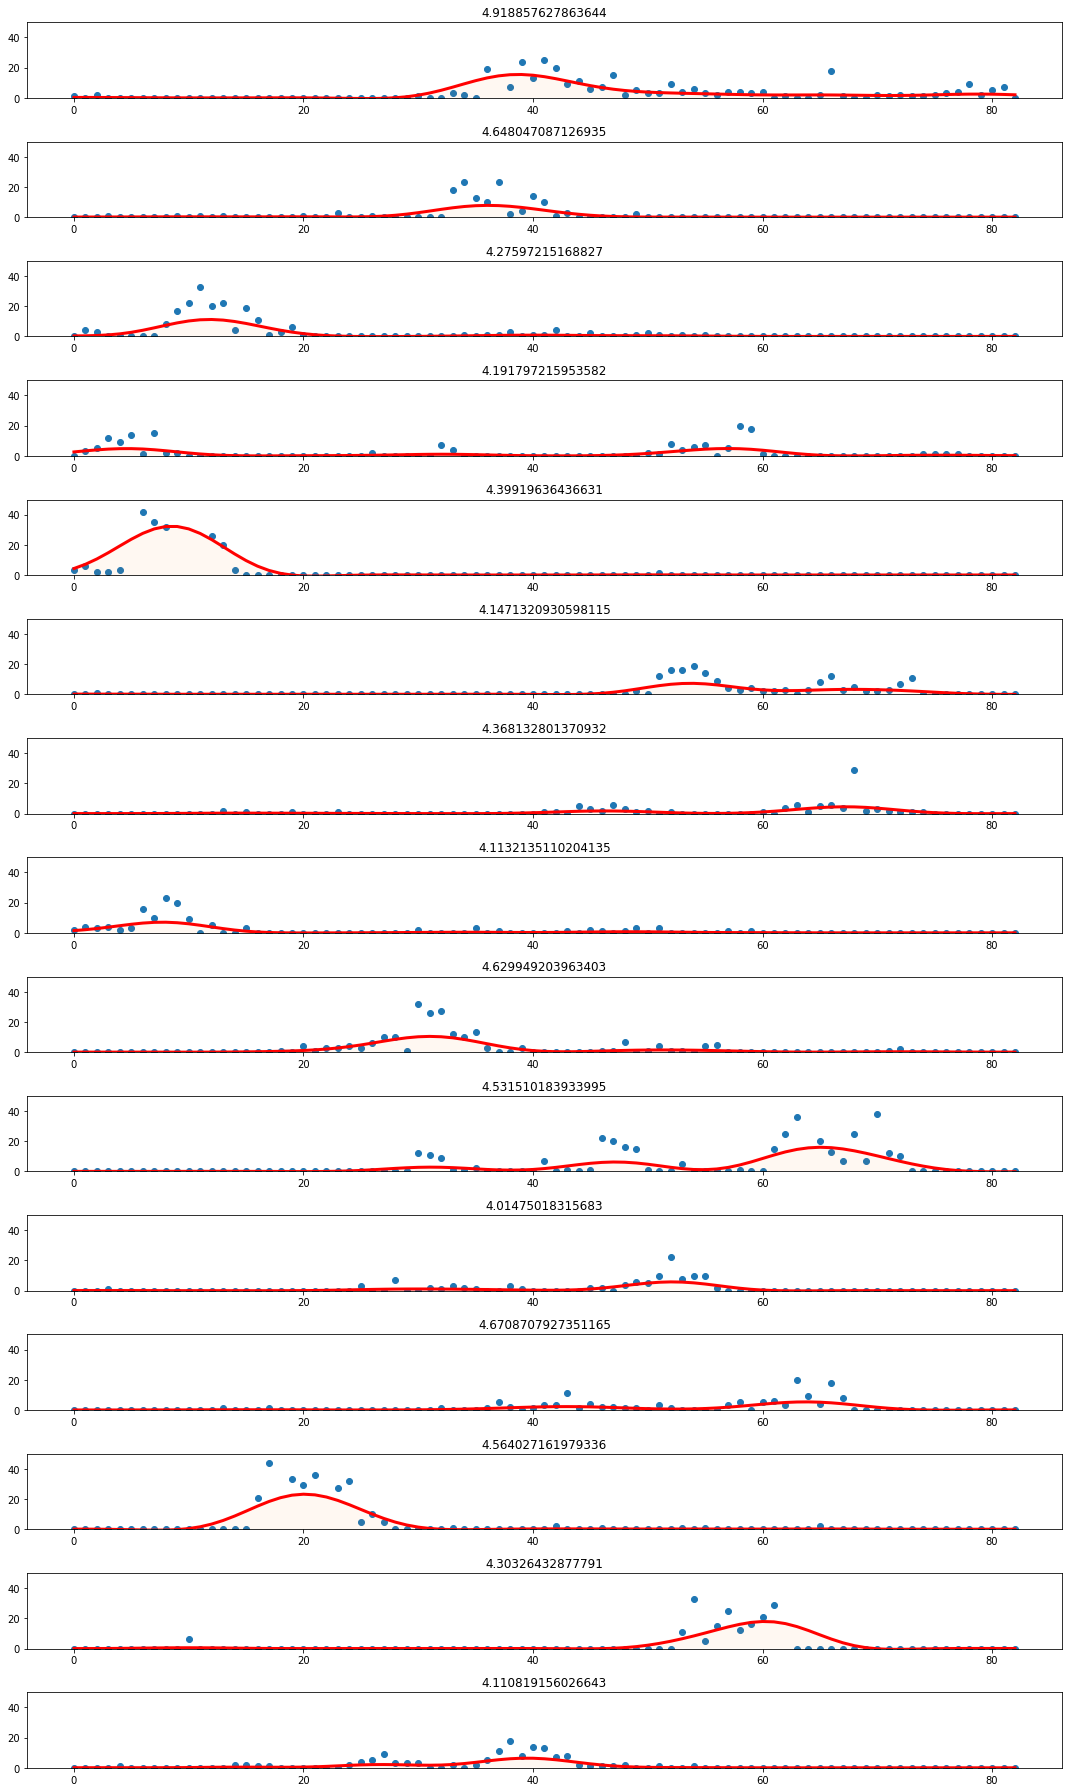

In [421]:
fig, ax = plt.subplots(15,figsize=(15,25))
i = 0
for j in np.where((np.array(output) > 4)&(np.array(output) < 5))[0][:15]:
    
    y = work[j]
    X = np.arange(len(y)).reshape(-1,1)
    gpr.fit(X, y)
    mean, std = gpr.predict(X, return_std=True)
    
    ax[i].scatter(X[:,0], y)
    ax[i].plot(mean, label=gpr.kernel_.length_scale, lw=3, c='r')
    ax[i].fill_between(X[:,0], mean + 2*std, alpha=.05)
    ax[i].set_title(gpr.kernel_.length_scale)
    ax[i].set_ylim([0,50])
    i += 1
# ax.legend(loc='best')
fig.tight_layout()

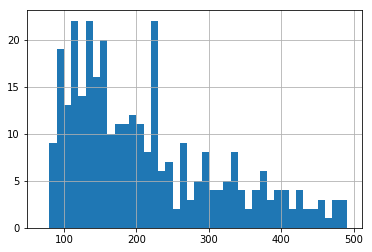

In [422]:
df.groupby('UserId').agg('sum').edit_count.hist(bins=np.arange(70,500,10))

(array([39., 52., 64., 36., 32., 19., 17., 17.,  9., 46.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

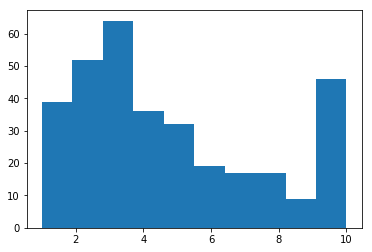

In [423]:
plt.hist(np.array(output))

(array([66., 70., 44., 42., 36., 24., 22., 14., 10.,  3.]),
 array([ 0. ,  7.9, 15.8, 23.7, 31.6, 39.5, 47.4, 55.3, 63.2, 71.1, 79. ]),
 <a list of 10 Patch objects>)

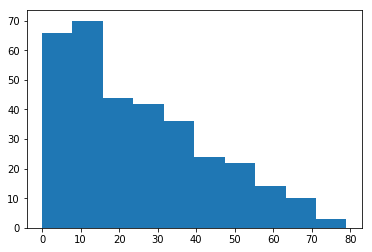

In [426]:
plt.hist(max_rate)

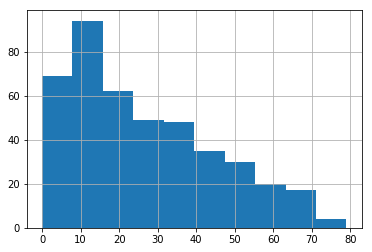

In [428]:
(df_silver_badge_date.days//7).hist()

# Simulations

In [564]:
# results = np.zeros()
alphas = np.arange(.1,5,.1)
betas = np.arange(.5,15,.5)
results = np.zeros(shape=(len(alphas), len(betas)))

for i,alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        num_thresh = []
        for k in range(100):
            count = 0
            all_ = []
            while count < 50:
                rate = np.random.gamma(alpha, beta)
                this_day = np.random.poisson(rate)
                all_.append(this_day)
                count += this_day
        #         day += 1
            all_ = np.array(all_)
            num_thresh.append(np.mean(this_day >= all_))
            
        results[i,j] = np.mean(num_thresh)

In [565]:
results

array([[0.99476391, 0.98924615, 0.9823538 , ..., 0.95291574, 0.96403634,
        0.95990201],
       [0.98937244, 0.97630747, 0.968275  , ..., 0.93633169, 0.89318394,
        0.9214625 ],
       [0.98298737, 0.96655522, 0.95333853, ..., 0.89994597, 0.90243242,
        0.90047399],
       ...,
       [0.80209548, 0.76621692, 0.72621889, ..., 0.97166667, 0.98      ,
        0.97166667],
       [0.79574516, 0.76362619, 0.76622619, ..., 0.985     , 0.985     ,
        0.98      ],
       [0.76428199, 0.78365157, 0.75773341, ..., 0.98      , 0.97      ,
        0.985     ]])

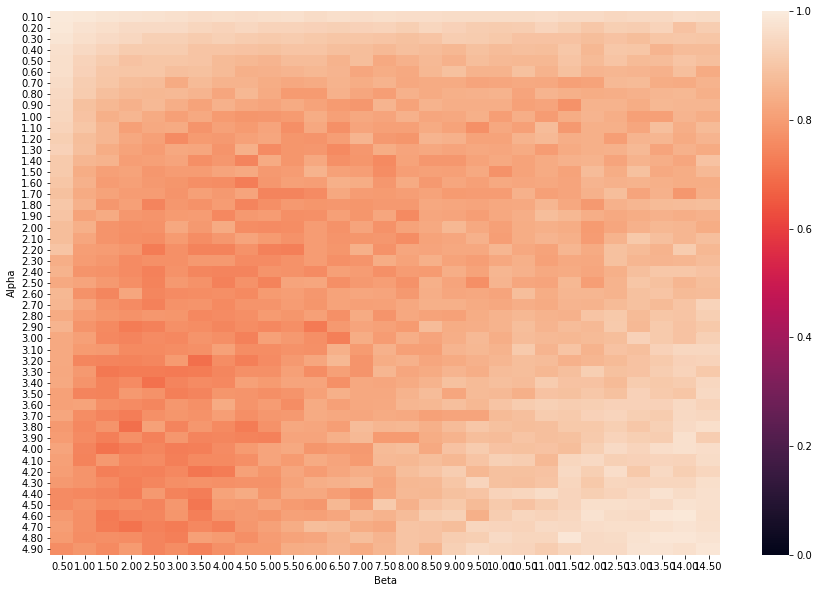

In [566]:
import seaborn as sns

fig, ax = plt.subplots(1,1,figsize=(15,10))

sns.heatmap(results, robust=True, vmin=0, vmax=1, ax=ax)
ax.set_ylabel('Alpha')
ax.set_xlabel('Beta')

ax.set_yticklabels(['%0.2f'%a for a in alphas])
ax.set_xticklabels(['%0.2f'%b for b in betas])

plt.show()

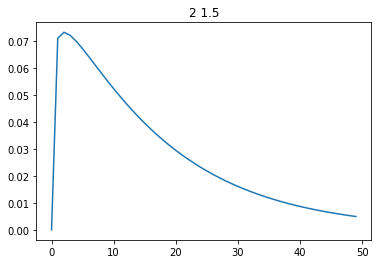

In [617]:
alpha = .1
beta = 15
nbinom_alpha_beta = stats.nbinom(alpha,1/(1+beta))

vals = []
for i in range(50):
    vals.append(i * nbinom_alpha_beta.pmf(i))

plt.title(f'{np.argmax(vals)} {nbinom_alpha_beta.mean()}')
plt.plot(vals)

In [ ]:
np.choose()

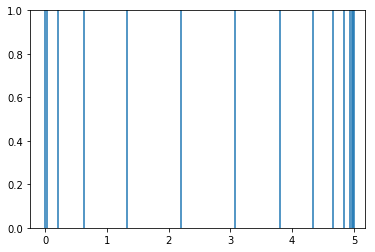

In [520]:
from scipy import stats

lengths = []
l = 0
for i in range(15):
    l += i * stats.poisson(5).pmf(i)
    lengths.append(l)
    plt.axvline(l)

In [11]:
import pystan

In [137]:
model_code = '''
data {
    int<lower=1> N;
    real x[N];
    vector<lower=0>[N] y;
    real delta;
}

parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
    real<lower=0> sigma;
    vector[N] eta;
}

model {
    vector[N] f; 
    {
        matrix[N, N] L_K;
        matrix[N, N] K = cov_exp_quad(x, alpha, rho);
    
        // diagonal elements
        for (n in 1:N) 
            K[n, n] = K[n, n] + delta;

        L_K = cholesky_decompose(K);
        f = L_K * eta;
    }
    
    rho ~ inv_gamma(5, 5);
    alpha ~ normal(0, 1);
    sigma ~ normal(0, 1);
    eta ~ normal(0, 1);
    
    y ~ normal(f, sigma); 
}

generated quantities {
    vector[N] f; 
    {
        matrix[N, N] L_K;
        matrix[N, N] K = cov_exp_quad(x, alpha, rho);
    
        // diagonal elements
        for (n in 1:N) 
            K[n, n] = K[n, n] + delta;

        L_K = cholesky_decompose(K);
        f = L_K * eta;
    }
}
'''

In [138]:
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b9e09236d0a5b616c6c7283af6bb347c NOW.


In [144]:
y = work[1].astype(int)
X = np.arange(0,len(y))

# X = X[y > 0]
# y = y[y > 0]

data = {'N': len(y), 'x': X, 'y': y, 'delta': 1e-9}
fit = model.sampling(data=data)

In [145]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_b9e09236d0a5b616c6c7283af6bb347c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho       1.15    0.12    0.9   0.47   0.64   0.94   1.35   3.03     62   1.05
alpha      1.9    0.45   1.08   0.14   1.09   1.76   2.58   3.96      6   1.43
sigma     3.52    0.35   0.74    1.9   3.28   3.72   4.02   4.53      4   1.73
eta[1]    0.31    0.02   0.89  -1.51  -0.21   0.33   0.78   2.16   2688    1.0
eta[2]    0.41    0.07   1.08  -1.55  -0.31   0.29    1.1   2.76    218   1.02
eta[3]    1.33    0.25    1.3  -0.83   0.35   1.25   2.25   3.94     26   1.09
eta[4]    3.05    1.15   2.66  -0.88   1.04   2.41    4.8   8.19      5   1.44
eta[5]   -0.02    0.02    0.9  -1.82  -0.56  -0.05   0.57   1.79   1721    1.0
eta[6]   -0.02    0.04   0.87  -1.71  -0.58  -0.05   0.55   

In [146]:
params = fit.extract(permuted=True)

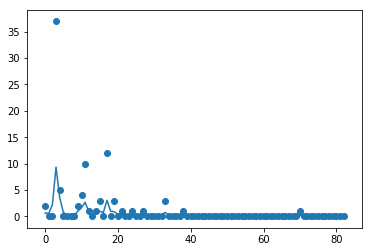

In [147]:
plt.plot(X, np.mean(params['f'], axis=0))
plt.scatter(X, y)

In [165]:
import GPy
kernel = GPy.kern.RBF(1, variance=1.0, lengthscale=1.0)
poisson_likelihood = GPy.likelihoods.Poisson()
laplace_inf = GPy.inference.latent_function_inference.Laplace()

t_distribution = GPy.likelihoods.StudentT(deg_free=5.0, sigma2=2.0)
laplace = GPy.inference.latent_function_inference.Laplace()

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Text(0,0.5,'Buses counts per 30 minutes')

 /home/nick/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


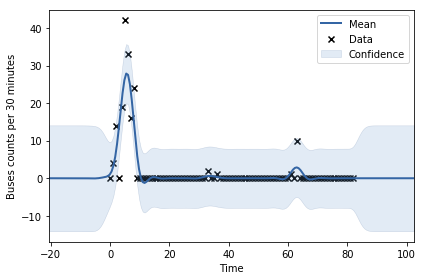

In [168]:
y = work[0].astype(int)
X = np.arange(0,len(y))

k2 = GPy.kern.RBF(1, variance=1.0, lengthscale=1.0)
k1 = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[0], period=7, lower=-10, upper=10)

kern = k2
# m = GPy.core.GP(X[:,None], y[:,None], kernel=kern)

m = GPy.models.GPRegression(X[:,None], y[:,None], kernel=(k2))
m.optimize()
#Predictions of counts of buses, including noise arising from Poisson noise
m.plot()
plt.xlabel('Time')
plt.ylabel('Buses counts per 30 minutes')

In [169]:
m

GP_regression.,value,constraints,priors
rbf.variance,39.041474133003526,+ve,
rbf.lengthscale,2.712132179016778,+ve,
Gaussian_noise.variance,12.61803681752574,+ve,



Name : GP regression
Objective : 102.8434021788704
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  0.7870252118300542  |      +ve      |        
  rbf.lengthscale          |   4.225050384047244  |      +ve      |        
  Gaussian_noise.variance  |  0.4609168161686543  |      +ve      |        


Text(0,0.5,'Buses counts per 30 minutes')

 /home/nick/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


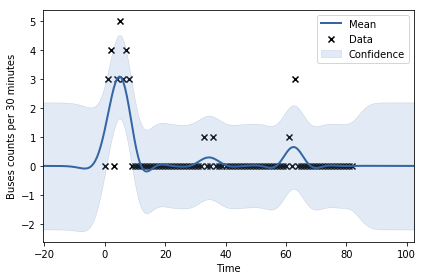

In [107]:
m.optimize()
print(m)

#Predictions of counts of buses, including noise arising from Poisson noise
m.plot()
plt.xlabel('Time')
plt.ylabel('Buses counts per 30 minutes')

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as par

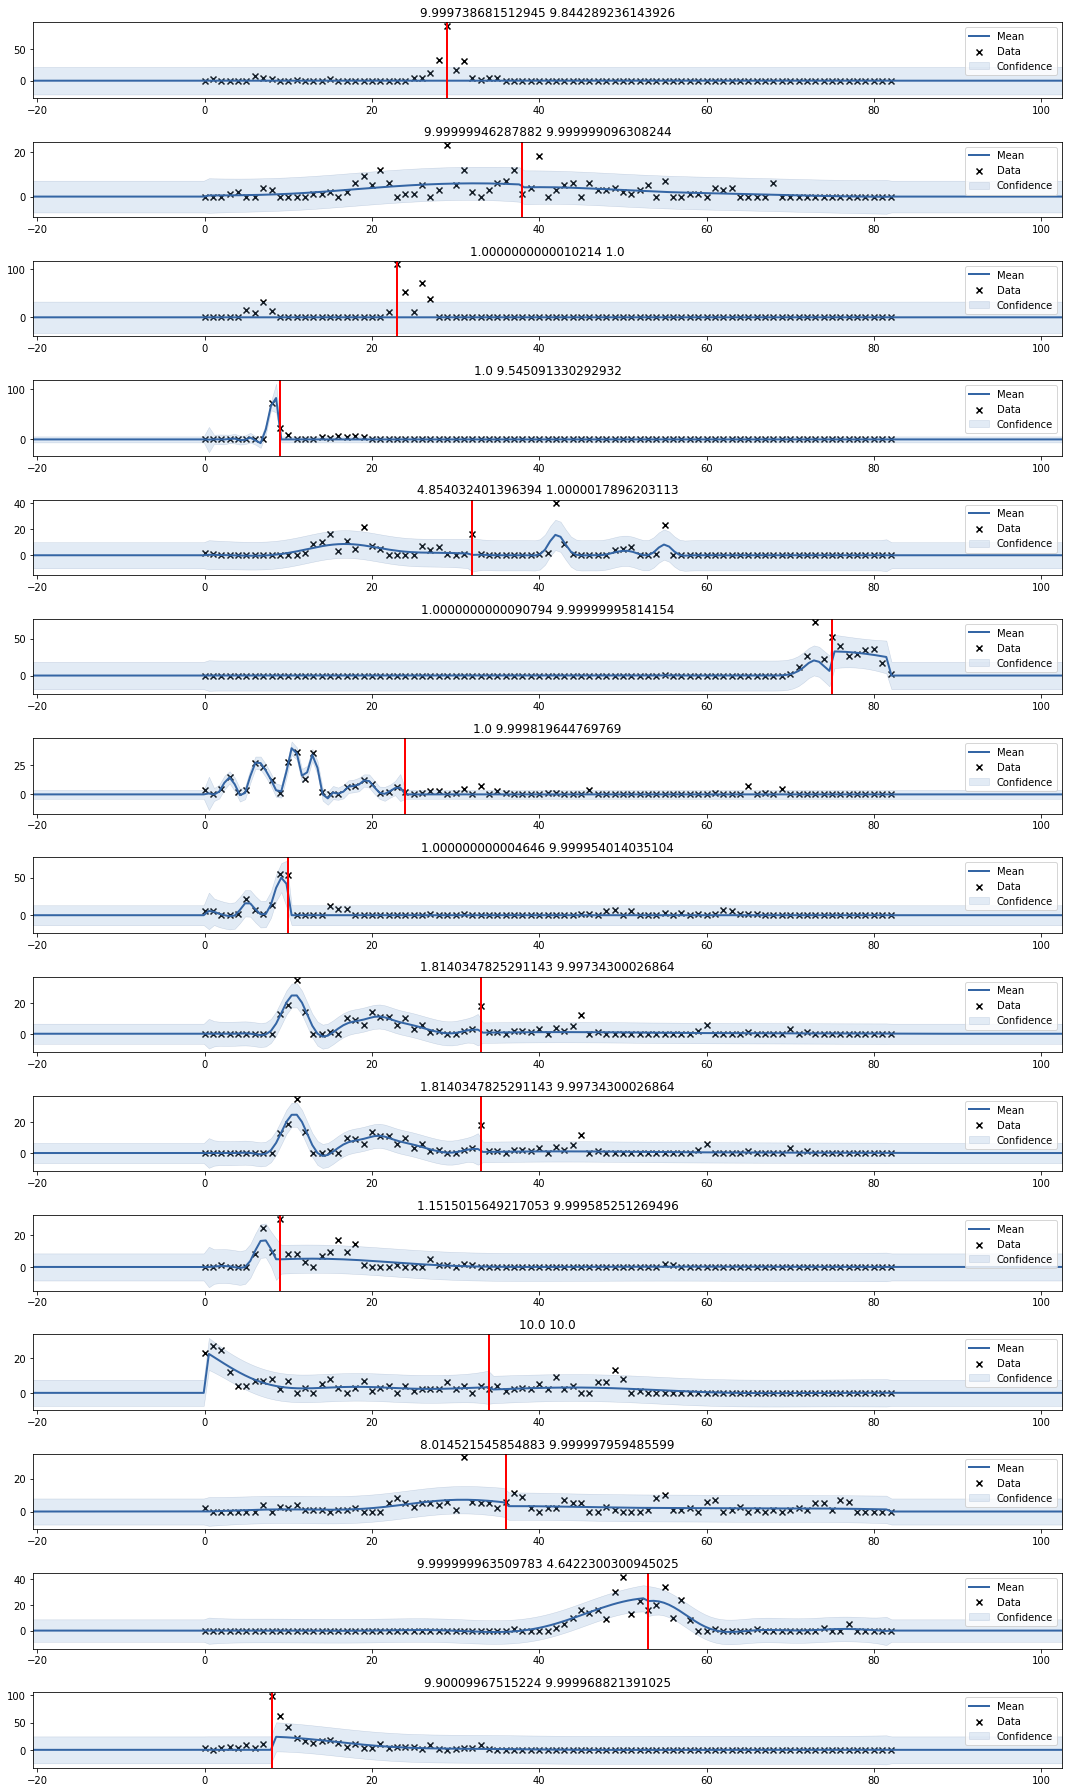

In [349]:
fig, ax = plt.subplots(15,figsize=(15,25))

for i in range(15):
    
    user = np.random.choice(df.UserId.unique())
    user_df = df[df.UserId == user]
    badge = df_silver_badge_date[df_silver_badge_date.UserId == user]
    bdays = badge.days.values[0]//7
    max_ = df.weeks.max()
    work = np.zeros(max_ + 1)
    for w, edits in user_df.groupby('weeks'):
        work[w] = edits.edit_count.sum()
    work

    k1 = GPy.kern.DomainKernel(1,0,bdays)
    k1.variance.constrain_bounded(0,1)
    
    k2 = GPy.kern.DomainKernel(1,bdays,max_)
    k2.variance.constrain_bounded(0,1)
    
    k3 = GPy.kern.RBF(1, variance=1.0, lengthscale=5.0)
    k3.lengthscale.constrain_bounded(1.0, 10.0)
    
    k4 = GPy.kern.RBF(1, variance=1.0, lengthscale=5.0)
    k4.lengthscale.constrain_bounded(1.0, 10.0)
    
    kern = k1 * k3 + k2 * k4 
    
    y = work
    X = np.arange(len(y))[:,None]
    
    m = GPy.models.GPRegression(X, y[:,None], kernel=kern)
    m.optimize()
    
#     ax[i].scatter(X[:,0], y)
    m.plot(ax=ax[i])
    ax[i].axvline(bdays, c='r', lw=2)
    ax[i].set_title(f'{m.sum.mul.rbf.lengthscale.values[0]} {m.sum.mul_1.rbf.lengthscale.values[0]}')
#     ax[i].set_title(f'{bdays}, {m.sum.rbf.lengthscale.values[0]}, {m.sum.logistic.slope.values[0]}, {m.sum.logistic.variance.values[0]}')
# ax.legend(loc='best')
fig.tight_layout()

In [18]:
consistency

array([[0., 3., 4., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 4., ..., 0., 0., 0.],
       [2., 1., 1., ..., 0., 0., 0.],
       [4., 2., 0., ..., 0., 0., 0.]])

In [365]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

x = np.arange(0, len(work[0]))

xs1 = np.arange(1,len(work[0]),4)
xs2 = np.arange(1,len(work[0]),3)

X = np.zeros(shape=(len(x), len(xs2)+len(xs1)))

for i,c in enumerate(xs1):
    x1 = rbf(x,0, s=c/2)
    X[:,i] = x1
    
for i,c in enumerate(xs2):
    x1 = rbf(x, c, s=3)
    X[:,len(xs1)+i] = x1

X.shape

(83, 49)

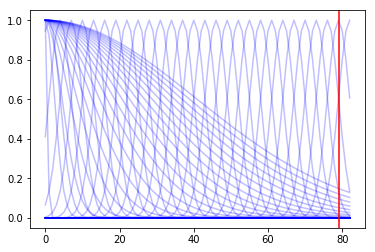

In [366]:
for x1 in X.T:
    plt.plot(x1, c='b', alpha=.25)
plt.axvline(bdge_max, c='r')

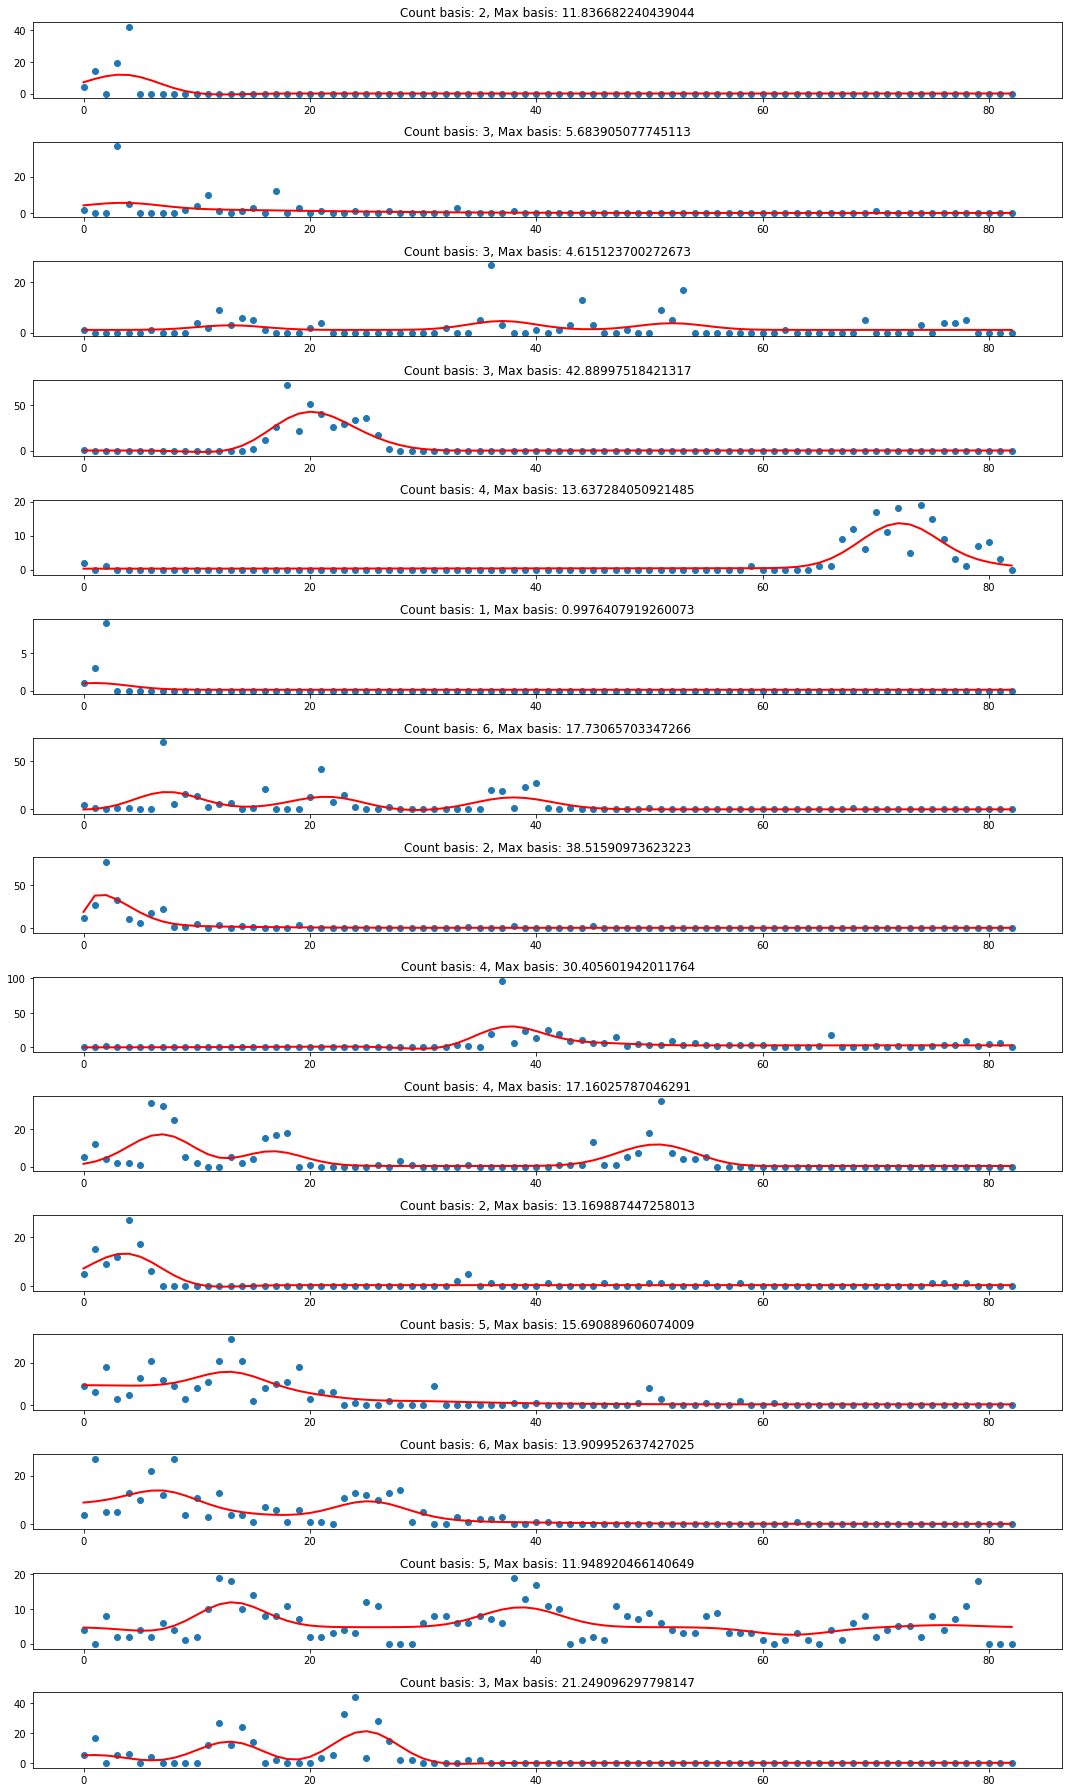

In [367]:
from sklearn import linear_model

fig, ax = plt.subplots(15,figsize=(15,25))

for i in range(15):

    reg = linear_model.Lasso(alpha=1e-1)
    y = work[i]

    reg.fit(X, y)
    
    pred = reg.predict(X)
    ax[i].plot(pred, c='r', lw=2)
    ax[i].scatter(x, y)
    ax[i].set_title(f'Count basis: {np.sum(reg.coef_ > 0)}, Max basis: {np.max(pred)}')
    
fig.tight_layout()

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0,0.5,'Number of basis functions used')

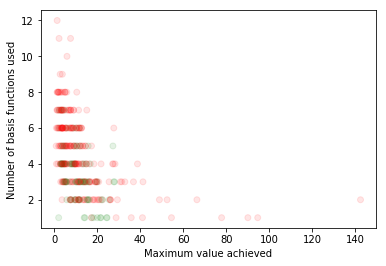

In [395]:
cb, nb = [], []
trajectories = {}
components = []
basis_used= []
for i, w in enumerate(work):

    reg = linear_model.Lasso(alpha=5e-2)
    y = work[i]

    reg.fit(X, y)
    
    coef = np.sum(reg.coef_ > 0)
    
    cb.append(coef)
    nb.append(np.mean(reg.coef_[reg.coef_ > 0]))
    basis_used.append(1*(np.abs(reg.coef_) > 0)[:len(xs1)].any() + 2*(np.abs(reg.coef_) > 0)[len(xs1):].any())
    
    components.append(reg.coef_)
    
    if coef not in trajectories:
        trajectories[coef] = []
        
    trajectories[coef].append(w)
    
cb = np.array(cb)
nb = np.array(nb)

plt.scatter(nb, cb, alpha=.1, c=['g' if b == 2 else 'r' for b in basis_used])
plt.xlabel('Maximum value achieved')
plt.ylabel('Number of basis functions used')

In [396]:
components = np.array(components)
basis_used = np.array(basis_used)
components.max(axis=1).shape
basis_used

array([2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
       3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2,
       3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 3,
       3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2,
       3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3,
       2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3,

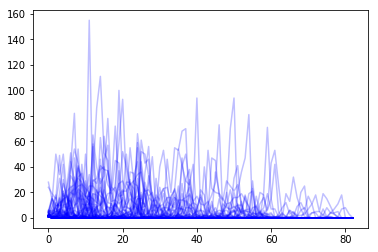

In [400]:
for w in work[basis_used == 2]:
    plt.plot(w, c='b', alpha=.25)

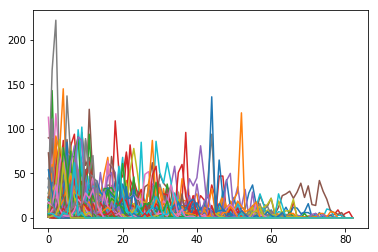

In [401]:
for w in work[basis_used == 3]:
    plt.plot(w)

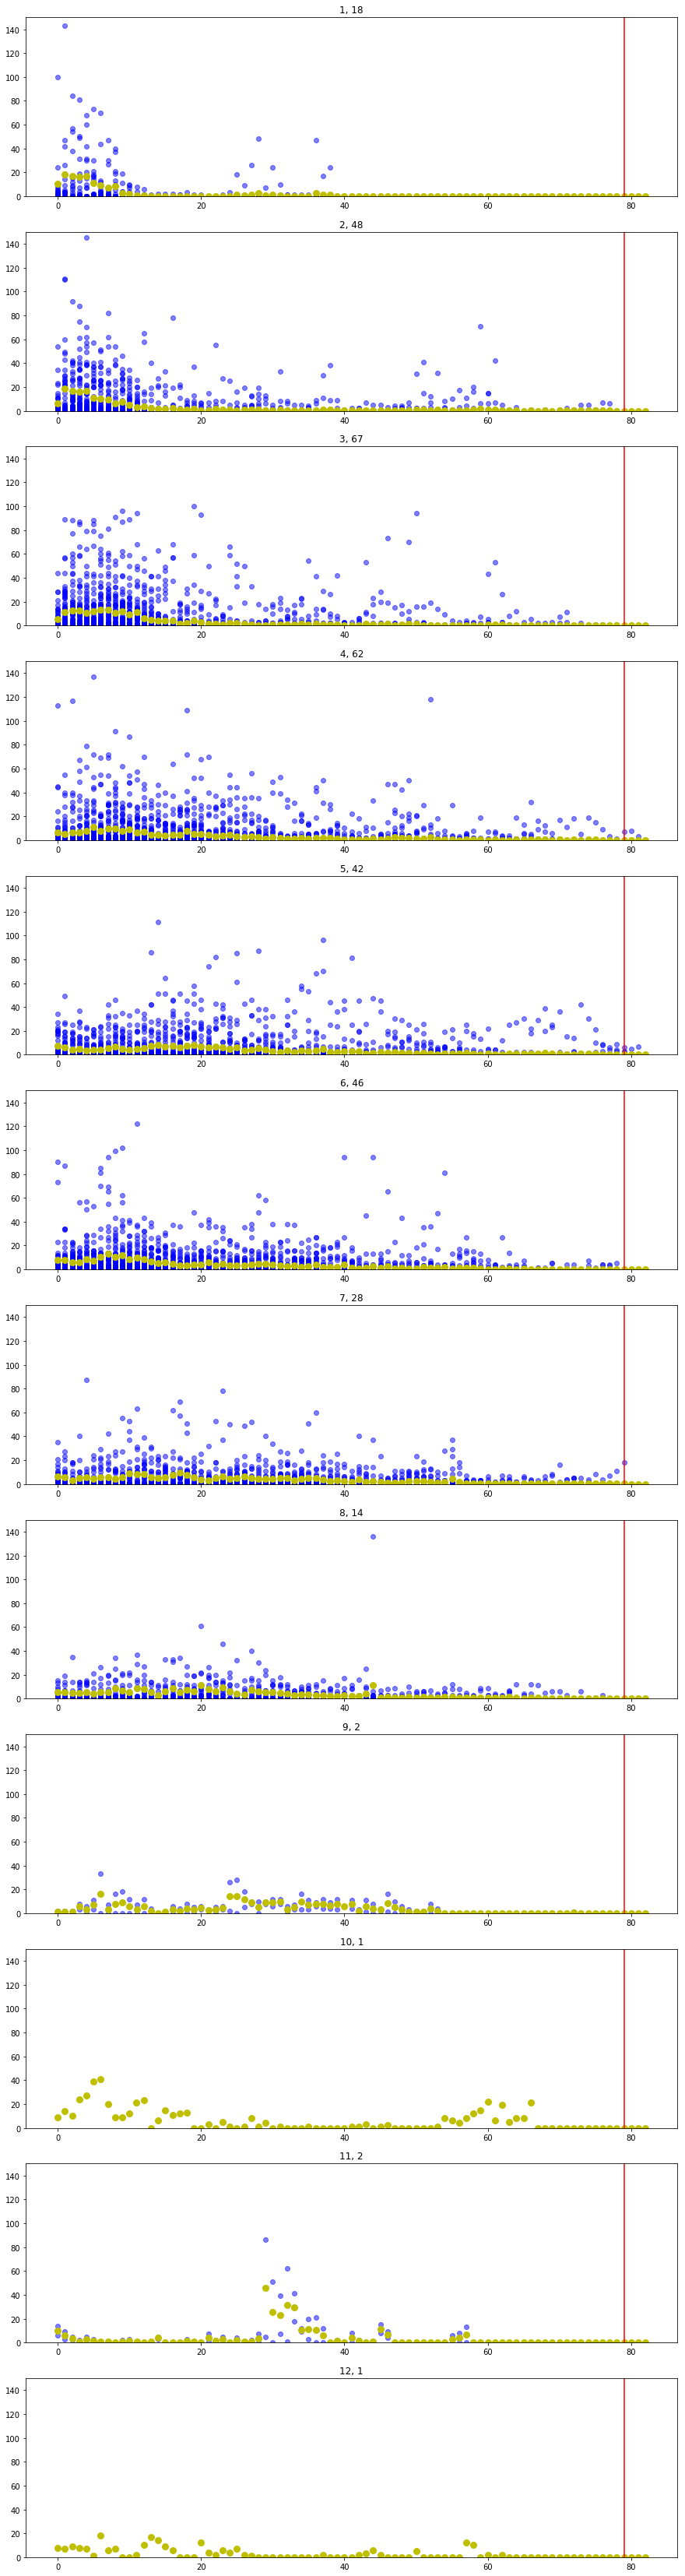

In [378]:
fig, ax = plt.subplots(len(trajectories.keys()), 1, figsize=(15,len(trajectories.keys())*5))
for i, k in enumerate(sorted(trajectories.keys())):
    ax[i].set_title(f'{k}, {len(trajectories[k])}')
    ax[i].set_ylim([0,150])
    for w in trajectories[k]:
        ax[i].scatter(x, w, alpha=.5, c='b')
    ax[i].scatter(x, np.mean(trajectories[k], axis=0), c='y', lw=3)
    ax[i].axvline(bdge_max, c='r')

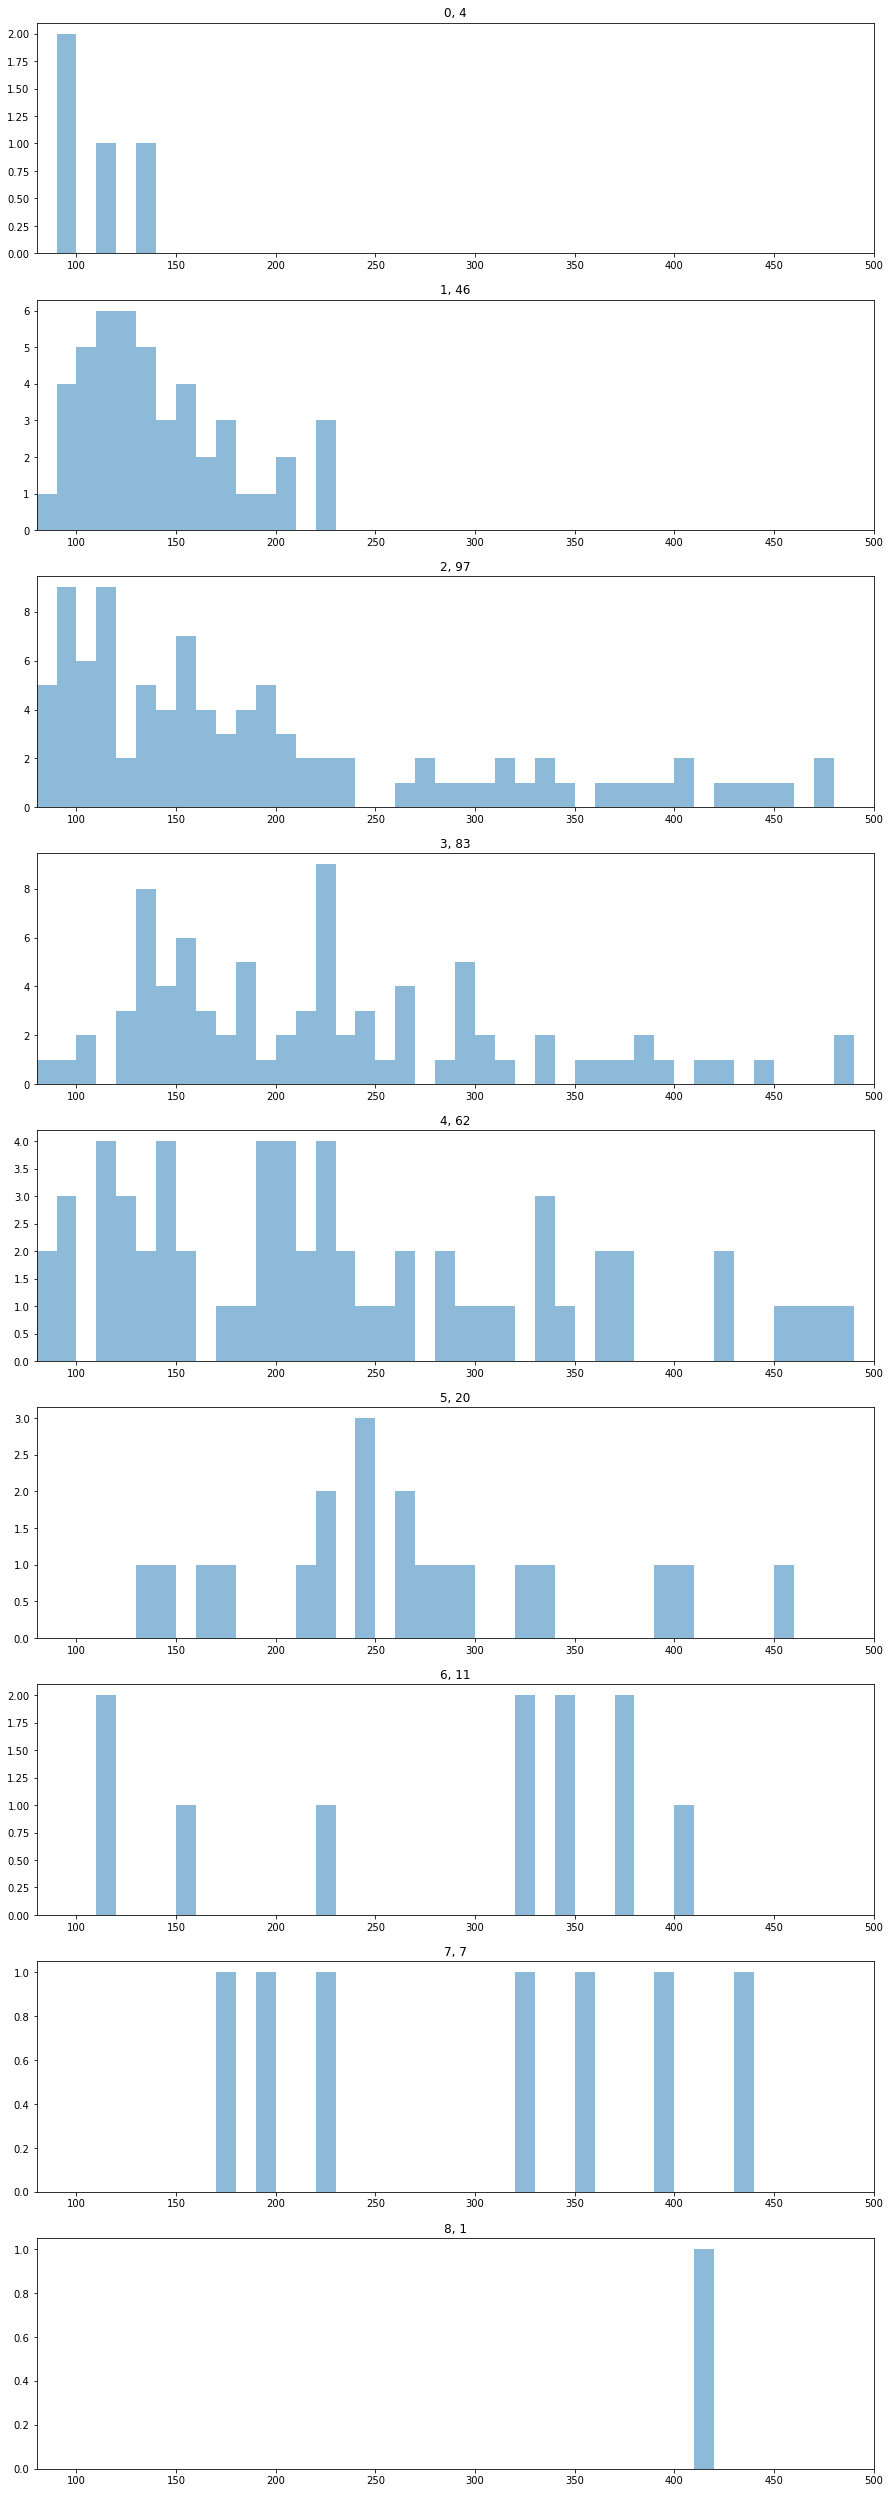

In [254]:
fig, ax = plt.subplots(len(trajectories.keys()), 1, figsize=(15,len(trajectories.keys())*5))
for i, k in enumerate(sorted(trajectories.keys())):
    ax[i].set_title(f'{k}, {len(trajectories[k])}')
    ax[i].set_xlim([80,500]) 
    t = np.sum(trajectories[k], axis=1)
    ax[i].hist(t, alpha=.5, bins=np.arange(80,500,10))

0.8830262823124201


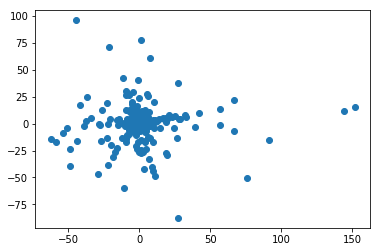

In [255]:
from sklearn.decomposition import PCA

components = components[components.max(axis=1) < 100]
components = components-np.mean(components, axis=0)
pca = PCA()
pca.fit(np.array(components))
print(np.sum(pca.explained_variance_ratio_[:10]))  
plt.scatter(*pca.transform(components).T[:2])

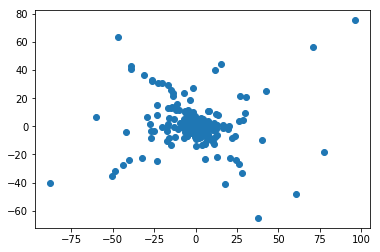

In [256]:
plt.scatter(*pca.transform(components).T[1:3])

In [135]:
pca.explained_variance_ratio_

array([4.64241705e-01, 2.73617288e-01, 5.96550666e-02, 3.93940818e-02,
       3.23717729e-02, 3.14244657e-02, 2.44800755e-02, 2.29110111e-02,
       1.09252456e-02, 6.78239430e-03, 5.14090997e-03, 4.66517135e-03,
       3.84623257e-03, 2.79930490e-03, 2.35632481e-03, 2.10571838e-03,
       1.89212093e-03, 1.69020891e-03, 1.28072003e-03, 1.03363477e-03,
       9.23530071e-04, 8.97168752e-04, 8.68006975e-04, 8.26101149e-04,
       6.95921742e-04, 5.36106626e-04, 5.18458156e-04, 4.19689457e-04,
       3.34935638e-04, 2.87919662e-04, 2.46177422e-04, 2.37036872e-04,
       2.24859933e-04, 1.48318493e-04, 8.80968952e-05, 7.10716603e-05,
       3.09868998e-05, 2.83153710e-05, 2.72368989e-06, 1.07961939e-06,
       2.22881968e-08, 1.96392634e-08, 9.16396483e-32, 3.35879268e-33,
       3.35879268e-33, 3.35879268e-33, 3.35879268e-33, 3.35879268e-33,
       3.35879268e-33, 3.35879268e-33, 3.35879268e-33, 3.31366876e-33,
       2.98053426e-33])

27
26
30
25
24
28
29


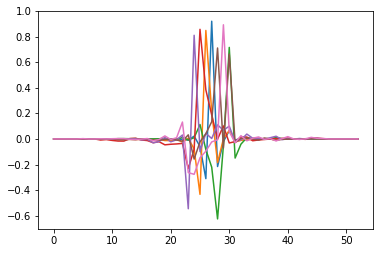

In [136]:
for c in pca.components_[:7]:
    plt.plot(c)
    print(np.argmax(c))

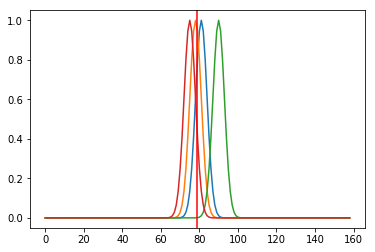

In [138]:
plt.plot(X[:,27])
plt.plot(X[:,26])
plt.plot(X[:,30])
plt.plot(X[:,25])
plt.axvline(bdge_max, c='r')

In [53]:
consistency_difference = np.diff(week_consistency, axis=1)
consistency_difference

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1., -2.,  0.],
       [ 1., -1.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 2.,  1., -1., ...,  0.,  0.,  0.],
       [ 2.,  1.,  0., ...,  0.,  0.,  0.],
       [-1., -2.,  3., ...,  0.,  0.,  0.]])

In [239]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

from sklearn.decomposition import PCA, KernelPCA

0.6514382406335774


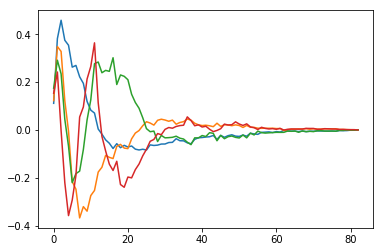

In [330]:
pca = PCA()
pca.fit(np.array(work))
print(np.sum(pca.explained_variance_ratio_[:10]))
plt.plot(pca.components_[0])
plt.plot(pca.components_[1])
plt.plot(pca.components_[2])
plt.plot(pca.components_[3])

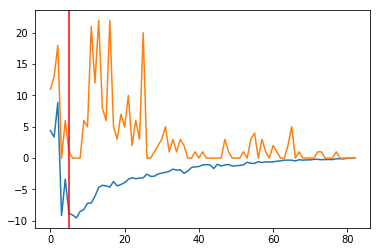

In [349]:
k = 25
vec = copy.deepcopy(work[k])
vec[5:] = 0
vec = vec.reshape(1,-1)

plt.plot(pca.transform(vec).dot(pca.components_)[0])
plt.plot(work[k])
plt.axvline(5, c='r')

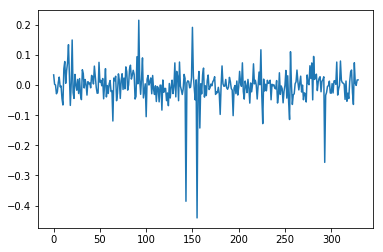

In [324]:
# plt.plot(X_kpca[4])
plt.plot(X_kpca[40])

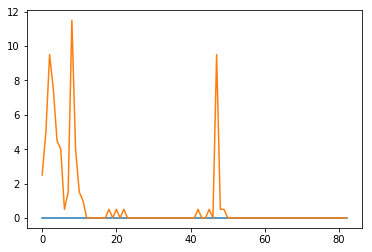

In [325]:
v = np.random.multivariate_normal(np.mean(X_kpca, axis=0), np.cov(X_kpca.T))
plt.plot(kpca.inverse_transform(v.reshape(1,-1))[0])
plt.plot(X_back[40])

In [249]:
beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(const)

ValueError: shapes (41,83) and (331,4) not aligned: 83 (dim 1) != 331 (dim 0)

In [220]:
y = np.sum(work, axis=1)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10)
rf.fit(const, y[:,None])
rf.predict(X)

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


array([167.50040906, 192.14070407, 217.61435052, 151.86925282,
       143.88748591, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76707024,
       189.76707024, 189.76707024, 189.76707024, 189.76

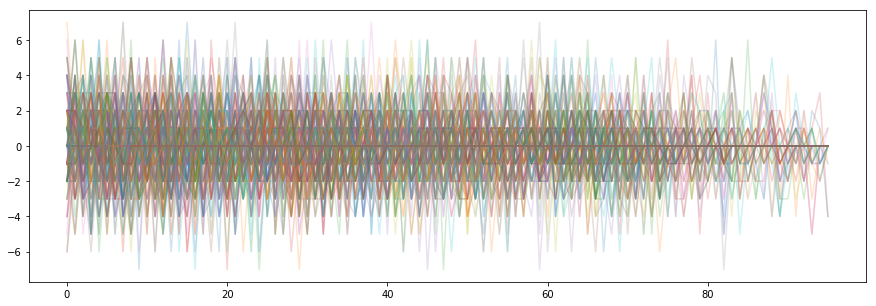

In [56]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
for user_traj in consistency_difference:
    ax.plot(user_traj, alpha=.2)

In [117]:
m.kern.lengthscale.values[0]

2.9383051077531195

INFO:paramz.transformations:Warning: changing parameters to satisfy constraints


{'covariance': [[<matplotlib.lines.Line2D at 0x7f6a2548bda0>]]}

 /home/nick/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


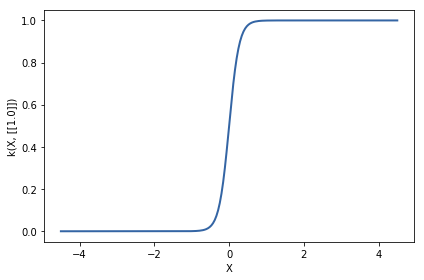

In [331]:
k1 = GPy.kern.LogisticBasisFuncKernel(1, centers=[0], variance=1.0, slope=-10)
# k1.variance.constrain_bounded(0,10)
k1.slope.constrain_bounded(5.0,10.0)

k2 = GPy.kern.RBF(2, variance=1.0, lengthscale=5.0)
k3 = GPy.kern.RBF(2, variance=1.0, lengthscale=5.0)

kern = k1 + k2 
k1.plot()

In [335]:
GPy.kern.DomainKernel(1,0,5)

constant_domain.,value,constraints,priors
variance,1.0,+ve,


In [315]:
GPy.kern.Bias(1)

bias.,value,constraints,priors
variance,1.0,+ve,


# Plot the number of days worked in a week as a function of number of edits made

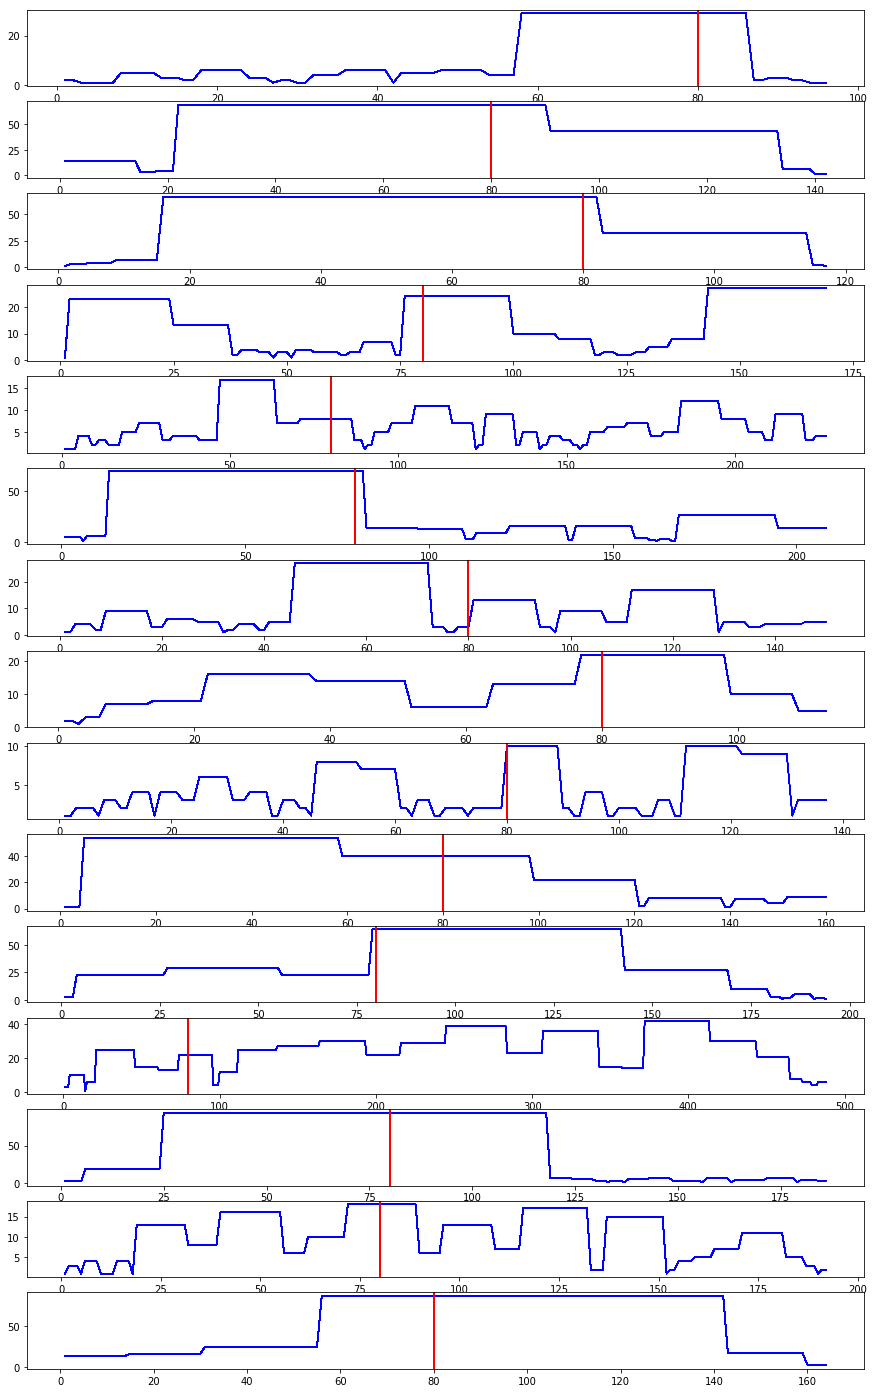

In [452]:
fig, ax = plt.subplots(15,figsize=(15,25))

for p, v in enumerate(np.random.choice(np.arange(0,len(work),1), size=15, replace=False)):
    trajectory = work[v]
    

    week_counter = 0
    last_num_edits = 1
    days_worked_in_week = 0
    total_count_in_week = 0
    days_rest = 0
    
    y = []
    x = []
    for i,edit_count in enumerate(trajectory):
        
        if edit_count > 0:
            
            total_count_in_week  = np.sum(trajectory[int(np.floor(i/7))*7:int(np.floor(i/7)*7+7)])
            days_worked_in_week += 1
            for k in range(int(edit_count)):
                y.append(total_count_in_week)
                x.append(last_num_edits)
                last_num_edits += 1
            days_rest = -1
        days_rest += 1
        week_counter += 1
        if week_counter >= 7:
            week_counter = 0
            days_worked_in_week = 0
            total_count_in_week = 0
            
        ax[p].plot(x, y, lw=1, c='b')
        ax[p].axvline(80, c='r')
#         ax[p].set_xlim([0,300])

# Look at all of the users

In [566]:
df_posts = pd.read_csv('./../data/users_posts.csv')
df_edits = pd.read_csv('./../data/users_edits.csv')

In [567]:
df_posts.head()

,Id,Reputation,CreationDate,Id.1,CreationDate.1,PostTypeId
0,6451573,98356,2016-06-10 19:19:53,37755913,2016-06-10 19:34:30,2
1,6471538,5559,2016-06-15 20:17:59,37845180,2016-06-15 20:28:33,2
2,6471538,5559,2016-06-15 20:17:59,37845348,2016-06-15 20:39:20,2
3,6471538,5559,2016-06-15 20:17:59,37845560,2016-06-15 20:52:45,2
4,6451573,98356,2016-06-10 19:19:53,37845606,2016-06-15 20:55:12,2


In [568]:
df_edits.head()

,Id,Reputation,CreationDate,Id.1,CreationDate.1,PostHistoryTypeId
0,6408573,2326,2016-06-01 08:45:54,120038503,2016-06-09 10:08:14,5
1,6408573,2326,2016-06-01 08:45:54,120312339,2016-06-13 12:42:05,5
2,6433023,54280,2016-06-07 02:12:58,120051764,2016-06-09 12:46:56,5
3,6433023,54280,2016-06-07 02:12:58,119867905,2016-06-07 12:15:54,5
4,6433023,54280,2016-06-07 02:12:58,120149637,2016-06-10 15:03:10,5


In [569]:
print(f'Unique users with posts: {len(np.unique(df_posts.Id))}')
print(f'Unique users with edits: {len(np.unique(df_edits.Id))}')

users = set(np.unique(df_posts.Id)).intersection(set(np.unique(df_edits.Id)))
print(f'Unique users: {len(users)}')

Unique users with posts: 148
Unique users with edits: 148
Unique users: 148


In [570]:
df_posts.rename(columns={'Id': 'UserId', 'CreationDate': 'UserCreationDate', 'Id.1': 'PostId','CreationDate.1': 'PostCreationDate', 'PostTypeId': 'PostTypeId'}, inplace=True)
df_edits.rename(columns={'Id': 'UserId', 'CreationDate': 'UserCreationDate', 'Id.1': 'PostId','CreationDate.1': 'PostCreationDate', 'PostHistoryTypeId': 'PostTypeId'}, inplace=True)
df_posts['type'] = 'post'
df_edits['type'] = 'edit'
df_posts = df_posts[df_posts.UserId.isin(users)]
df_edits = df_edits[df_edits.UserId.isin(users)]

In [571]:
df = pd.concat([df_posts, df_edits])
df['days'] = (pd.to_datetime(df['PostCreationDate']) - pd.to_datetime(df['UserCreationDate'])).dt.days
df.head()

,UserId,Reputation,UserCreationDate,PostId,PostCreationDate,PostTypeId,type,days
0,6451573,98356,2016-06-10 19:19:53,37755913,2016-06-10 19:34:30,2,post,0
1,6471538,5559,2016-06-15 20:17:59,37845180,2016-06-15 20:28:33,2,post,0
2,6471538,5559,2016-06-15 20:17:59,37845348,2016-06-15 20:39:20,2,post,0
3,6471538,5559,2016-06-15 20:17:59,37845560,2016-06-15 20:52:45,2,post,0
4,6451573,98356,2016-06-10 19:19:53,37845606,2016-06-15 20:55:12,2,post,5


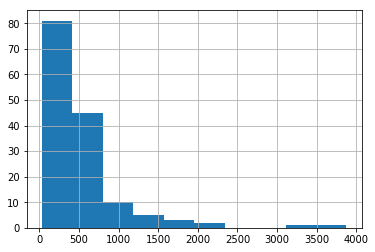

In [573]:
df.groupby('UserId').agg('count').PostId.hist()

In [574]:
users

{6408573,
 6412888,
 6426617,
 6427646,
 6428638,
 6433023,
 6439240,
 6446385,
 6448351,
 6449750,
 6451573,
 6461462,
 6463791,
 6464308,
 6468241,
 6468577,
 6471538,
 6472077,
 6489306,
 6496010,
 6498658,
 6507689,
 6521116,
 6523163,
 6523193,
 6525260,
 6529537,
 6530111,
 6530134,
 6530695,
 6534219,
 6535336,
 6539544,
 6551577,
 6554747,
 6555896,
 6556397,
 6557569,
 6560478,
 6563293,
 6572922,
 6578921,
 6583140,
 6595116,
 6597281,
 6599590,
 6608101,
 6612932,
 6614295,
 6620474,
 6622587,
 6622817,
 6624680,
 6625726,
 6633975,
 6637668,
 6640099,
 6648807,
 6650102,
 6652664,
 6654773,
 6655094,
 6656894,
 6657015,
 6670723,
 6671342,
 6676466,
 6677244,
 6677986,
 6680583,
 6680611,
 6710751,
 6711752,
 6714194,
 6715577,
 6738015,
 6742808,
 6751649,
 6756033,
 6760995,
 6765643,
 6779307,
 6781889,
 6788803,
 6789498,
 6811411,
 6811846,
 6813506,
 6850771,
 6857662,
 6862601,
 6879826,
 6887672,
 6910253,
 6910411,
 6950238,
 7011496,
 7023245,
 7023590,
 7031230,


75 115
472 492
287 428
117 262
304 617
108 128
3 38
240 393
282 435
385 713
164 225
164 225
348 635
320 396
840 1357


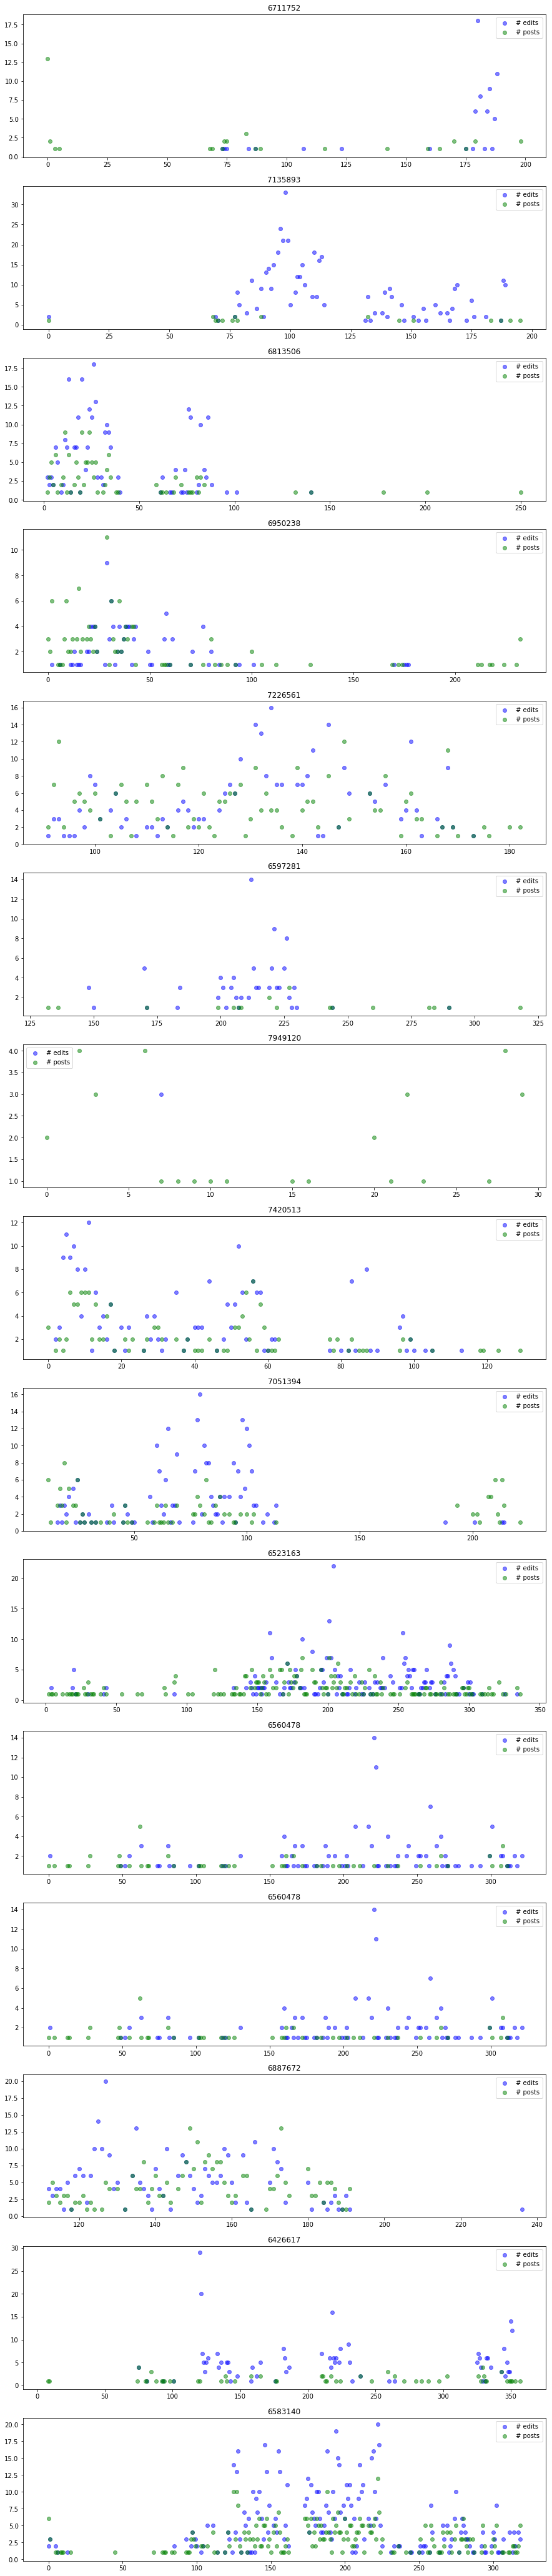

In [598]:
fig, axes = plt.subplots(15,1,figsize=(15, 5*15))

for i, ax in enumerate(axes):
    user = df[df.UserId == np.random.choice(list(users))]

    posts = user.groupby(['type', 'days']).agg('count').PostId.reset_index()
    posts.sort_values('days', inplace=True)

    posts_ = posts[posts.type.isin(['post'])]
    edits = posts[posts.type.isin(['edit'])]

    x = edits.days
    y = edits.PostId

    print(edits.PostId.sum(), posts.PostId.sum())

    ax.scatter(x,y,c='b',label='# edits', alpha=.5)
    ax.set_title(user.UserId.values[0])
    x = posts_.days
    y = posts_.PostId

    ax.scatter(x, y, c='g', label='# posts', alpha=.5)

    ax.legend(loc='best')

In [613]:
days_min = df.days.min()
days_max = df.days.max()
num_users = len(df.UserId.unique())

edit_trajectories = np.zeros(shape=(num_users, 2*days_max-days_min))
post_trajectories = np.zeros(shape=(num_users, 2*days_max-days_min))
u = 0
for g, user in df.groupby('UserId'):
    
    edits = user[user.type == 'edit']
    edits.sort_values('days', inplace=True)
    counts = edits.groupby(['days']).agg('count').PostId.cumsum()
    
    more_than_80 = np.where((counts >= 80))[0]
    if len(more_than_80) > 0:
        day_of_80 = np.min(more_than_80)
    
    
        for r, post in user.iterrows():
            if post.type == 'edit':
                edit_trajectories[u, post.days + days_max - day_of_80] += 1
            else:
                post_trajectories[u, post.days + days_max - day_of_80] += 1
        u += 1

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


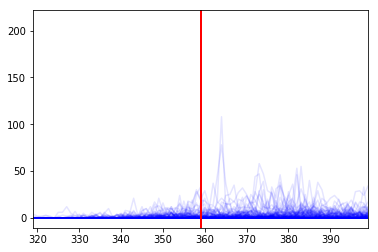

In [614]:
for traj in edit_trajectories:
    plt.plot(traj, alpha=.1, c='b')
plt.xlim([days_max-40, days_max+40])
plt.axvline(days_max, c='r', lw='2')
plt.show()

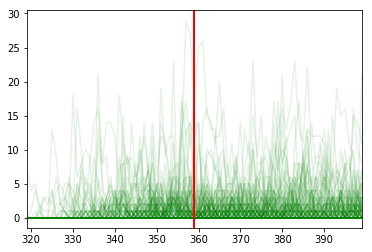

In [615]:
for traj in post_trajectories:
    plt.plot(traj, alpha=.1, c='g')
plt.xlim([days_max-40, days_max+40])
plt.axvline(days_max, c='r', lw='2')
plt.show()

In [616]:
df

,UserId,Reputation,UserCreationDate,PostId,PostCreationDate,PostTypeId,type,days
0,6451573,98356,2016-06-10 19:19:53,37755913,2016-06-10 19:34:30,2,post,0
1,6471538,5559,2016-06-15 20:17:59,37845180,2016-06-15 20:28:33,2,post,0
2,6471538,5559,2016-06-15 20:17:59,37845348,2016-06-15 20:39:20,2,post,0
3,6471538,5559,2016-06-15 20:17:59,37845560,2016-06-15 20:52:45,2,post,0
4,6451573,98356,2016-06-10 19:19:53,37845606,2016-06-15 20:55:12,2,post,5
5,6451573,98356,2016-06-10 19:19:53,37845747,2016-06-15 21:04:35,2,post,5
6,6471538,5559,2016-06-15 20:17:59,37845777,2016-06-15 21:06:37,2,post,0
7,6471538,5559,2016-06-15 20:17:59,37845885,2016-06-15 21:14:42,2,post,0
8,6471538,5559,2016-06-15 20:17:59,37846299,2016-06-15 21:44:25,2,post,0
9,6471538,5559,2016-06-15 20:17:59,37846518,2016-06-15 21:59:06,2,post,0
